# 4. Use the prediction and the data itself for data EDA
資料集：`VQA-Rad` 
訓練參數：QCR 法的 PubMedClip，batch size = 16，更細緻的可以看
`configs/qcr_pubmedclipRN50_ae_rad_16batchsize_withtfidf_nondeterministic.yaml`

[Project Init Slides](https://docs.google.com/presentation/d/18BzeLktMG1cwctLUF8baXRWEA_OnPvjtoolniKF79UI/edit#slide=id.g21ffbc74801_8_10)

1. Data Example。`question_type` 和 `phrase_type` 的數量。
2. `question_type` 和 `phrase_type` level 的 EDA（類別正確與錯誤率）。

## Path Specifications and Loading data 

In [1]:
!pwd

/home/nanaeilish/projects/mis


In [2]:
qcr_dir = 'PubMedCLIP/QCR_PubMedCLIP'
data_dir = 'PubMedCLIP/QCR_PubMedCLIP/data/data_rad'
imagedir = f'{data_dir}/images'
result_dir = 'PubMedCLIP/QCR_PubMedCLIP/results'

In [3]:
# from PIL import Image
# import matplotlib_pyplot as plt
# image_path = f'{imagedir}/synpic676.jpg'
# pic = Image.open(image_path)
# plt.imshow(pic) 

In [4]:
from typing import Union, List, Dict  
from pathlib import Path 
import pandas as pd 

def load_json(fp: Union[str, Path]):
    import json
    with open(fp, 'r') as f:
        return json.load(f)

def to_dataframe(data: List[Dict]):
    # data: List of dicts 
    # to data frame
    df = pd.DataFrame(data)
    return df 

In [5]:
# check data in testfile 
trainset = load_json(Path(data_dir)/"trainset.json") 
testset = load_json(Path(data_dir)/"testset.json")
trainset = to_dataframe(trainset)
testset = to_dataframe(testset) 

In [65]:
# get trainset open: closed 
trainset['answer_type'].value_counts() #??? 三小 

CLOSED     1821
OPEN       1241
CLOSED        2
Name: answer_type, dtype: int64

In [64]:
# get testset open: closed
testset['answer_type'].value_counts()

CLOSED    272
OPEN      179
Name: answer_type, dtype: int64

## Question Types
[Question/Ans Type Table](https://www.nature.com/articles/sdata2018251/tables/2)
[Paper (VQA-RAd)](https://www.nature.com/articles/sdata2018251#data-citations)
和原本調查時說的 Question Types 有四種：modality, plane, organ system, abnormality 多出超多 lol，好像還有 multi-label。
| Question Type        | Description                                                                                                      |
|----------------------|------------------------------------------------------------------------------------------------------------------|
| Modality             | How an image is taken – CT, x-ray, T2 weighted MRI, etc.                                                         |
| Plane                | Orientation of an image slicing through the body – axial, sagittal, coronal                                      |
| Organ System         | Categorization that connects anatomical structures with pathophysiology, diagnosis, and treatment – pulmonary, cardiac, musculoskeletal system  |
| Abnormality          | Normalcy of an image or object. For example, “is there something wrong with the image?” or “What is abnormal about the lung?”, “Does the liver look normal?” |
| Object/Condition Presence | Objects could be normal structures like organs or body parts but could also be abnormal objects such as masses or lesions. Clinicians may refer to the presence of conditions in an image or patient – fractures, midline shift, infarction |
| Positional reasoning | Position or location of an object or organ, including what side of a patient, in respect to the image borders, or relative to other objects in the image |
| Color                | Signal intensity including enhancement or opaqueness                                                             |
| Size                 | Measurement of size of an object, e.g., enlargement, atrophy                                                      |
| Attribute Other      | Other types of description questions                                                                              |
| Counting             | Focusing on a quantity of objects, e.g., number of lesions                                                        |
| Other                | Catch-all categorization for questions that do not fall into the previous categories                              |


| Answer Type          |                                                                                                                  |
|----------------------|------------------------------------------------------------------------------------------------------------------|
| Close-ended          | Yes/no and other limited choices. For example, “Is the mass on the left or right?”                               |
| Open-ended           | Do not have a limited question structure and could have multiple correct answers                                 |


In [6]:
print(trainset.shape, testset.shape)
# 我猜 Pres 是 Object/Condition Presence，POS 是 Position Reasoning [verified]
# 照順序來看 Position Reasoning，Abnormality, Size, Attribute, Modality, Plane, Color, Count 是幾個比較大的類別 
print('Train set:' , trainset['question_type'].value_counts())
print('Test set:' , testset['question_type'].value_counts())

(3064, 8) (451, 8)
Train set: PRES            1214
POS              496
ABN              312
SIZE             265
OTHER            169
MODALITY         154
ATTRIB           140
PLANE             94
COLOR             80
ORGAN             49
COUNT             39
PRES, ATTRIB      10
ATTRIB, PRES       6
POS, PRES          6
ABN, POS           5
PRES, POS          5
COLOR, PRES        4
POS, ABN           4
ATRIB              2
SIZE, COLOR        2
PRSE               2
Other              2
SIZE, PRES         2
ATTRIB, SIZE       1
PRES, ABN          1
Name: question_type, dtype: int64
Test set: PRES            163
POS              58
ABN              56
SIZE             45
MODALITY         33
OTHER            26
PLANE            26
ATTRIB           17
ORGAN            10
COUNT             6
COLOR             3
POS, PRES         2
PRES, ATTRIB      2
ATTRIB, PRES      1
SIZE, PRES        1
PRES, POS         1
PRES, COLOR       1
Name: question_type, dtype: int64


Text(0.5, 1.0, 'Train set Q type Pie Chart')

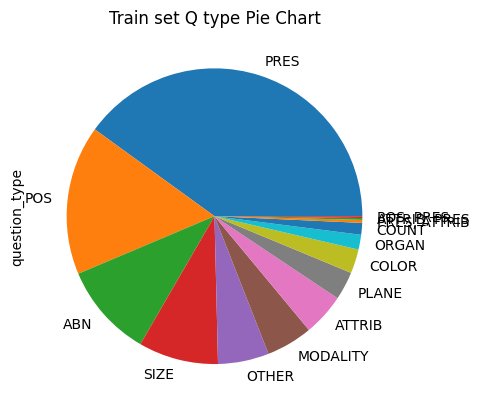

In [7]:
import matplotlib.pyplot as plt
train_f_counts = trainset['question_type'].value_counts().loc[lambda x: x >= 6]
train_f_counts.plot(kind='pie')
# title 
plt.title('Train set Q type Pie Chart')

Text(0.5, 1.0, 'Test set Q type Pie Chart')

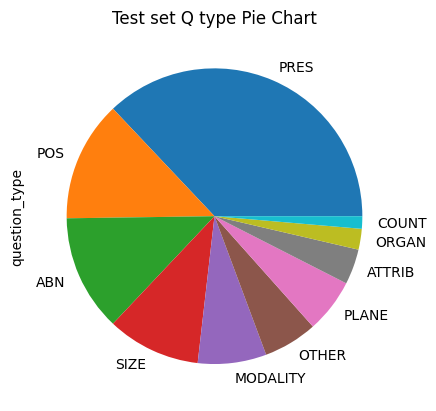

In [8]:
test_f_counts = testset['question_type'].value_counts().loc[lambda x: x >= 6]
test_f_counts.plot(kind='pie')
plt.title('Test set Q type Pie Chart')

## Show Example Data

In [9]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from IPython.display import display
import gc   
def show_example(dataset: pd.DataFrame, index = None, rseed= None):
    # show example 
    # make a copy 
    dataset = dataset.copy()
    if index is not None and rseed is not None:
        raise ValueError('index and rseed cannot be both set')
    if rseed: 
        random.seed(42)
    random_index = random.randint(0, len(dataset))
    if index is not None:
        random_index = index
    # reset index 
    dataset = dataset.reset_index(drop=True)
    print('Random index: ', random_index)
    print(f'Question: {dataset["question"][random_index]}')
    print(f'Answer: {dataset["answer"][random_index]}')
    print(f'Question type: {dataset["question_type"][random_index]}')
    print(f'Answer type: {dataset["answer_type"][random_index]}')
    img = Image.open(f'{imagedir}/{dataset["image_name"][random_index]}')
    del dataset
    gc.collect()
    plt.imshow(img)
    plt.show()

Random index:  2469
Question: What brain region demonstrates edema?
Answer: Basal Ganglia
Question type: POS, PRES
Answer type: OPEN


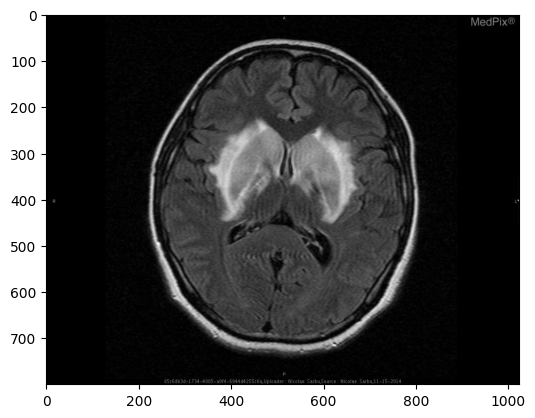

In [10]:
show_example(trainset)

Random index:  384
Question: Is the spleen present?
Answer: On the patient's left
Question type: PRES
Answer type: OPEN


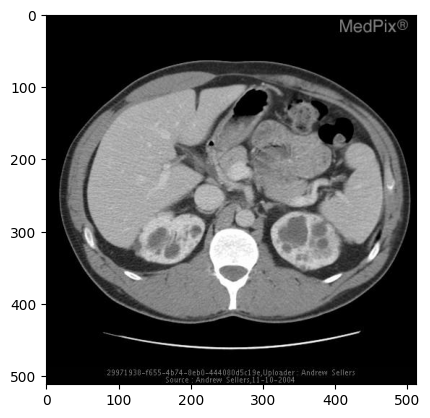

In [11]:
show_example(testset)

## Object/Condition Presence versus Position Reasoning
Pres 是 Object/Condition Presence，POS 是 Position Reasoning 

Random index:  732
Question: Is/Are there pleural effusion?
Answer: No
Question type: PRES
Answer type: CLOSED


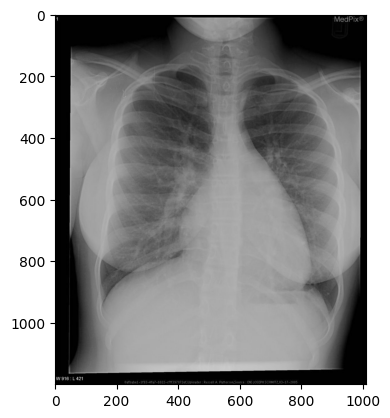

Random index:  83
Question: Which cardiac border is more prominently visualized?
Answer: Left
Question type: POS
Answer type: OPEN


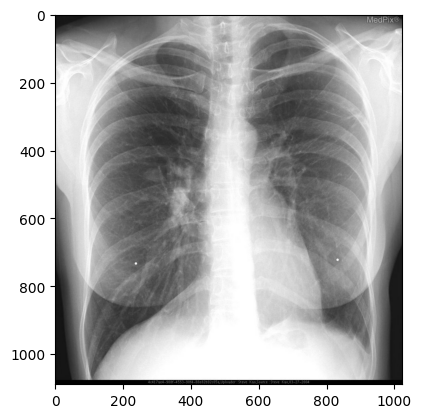

In [12]:
# find those with question_type == 'PRES'
# find those with question_type == 'POS'

train_pres = trainset[trainset['question_type'] == 'PRES']
train_pos = trainset[trainset['question_type'] == 'POS']
show_example(train_pres) # Is/Are there blurring of the grey-white matter in the patient's right temporal lobe? 
show_example(train_pos)  # Where is the mass located?

## Integrating the prediction results
1. Is Certain Q-typed Questions More Difficult to Answer than others? 
2. How are Object-Condition Presence (Pres) Questions answered? If they are badly answered, can object-detection techniques help? 
幹沒有看過有人這樣寫 test file 的
怎麼會弄出來 csv 裡面的答案放 tensor？？
這樣是要怎樣看差別？


In [13]:
correct_df = pd.read_csv(Path(result_dir)/'correct_predictions.csv')
incorrect_df = pd.read_csv(Path(result_dir)/'incorrect_predictions.csv')
# use testset, and question to map qid back 
# make a qid map 
# string: int, question: qid 
qid_map = testset[['question', 'qid']].set_index('question').to_dict()['qid']
qtype_map = testset[['qid', 'question_type']].set_index('qid').to_dict()['question_type']
for df in [correct_df, incorrect_df]:
    df['qid'] = df['question'].map(qid_map)
    df['question_type'] = df['qid'].map(qtype_map)

In [14]:
#  {"qid": 1205, "image_name": "synpic55286.jpg", "image_organ": "HEAD", "answer": "Right frontal lobe", "answer_type": "OPEN", "question_type": "POS", "question": "What lobe of the brain is the lesion located in?", "phrase_type": "freeform"}

In [15]:
# calculate open type, closed type count 
# open type:
# closed type:
print('correct')
print(correct_df.shape) 
print(correct_df['answer_type'].value_counts())

print('incorrect')
print(incorrect_df.shape)
print(incorrect_df['answer_type'].value_counts())

correct
(321, 8)
CLOSED    220
OPEN      101
Name: answer_type, dtype: int64
incorrect
(130, 8)
OPEN      66
CLOSED    64
Name: answer_type, dtype: int64


In [16]:
c = correct_df['answer_type'].value_counts().to_dict()
ic = incorrect_df['answer_type'].value_counts().to_dict()


In [17]:
# transform this to a dataframe
stats = pd.DataFrame(
    [{'correct':c['CLOSED'], 'incorrect': ic['CLOSED']}, 
    {'correct': c['OPEN'], 'incorrect': ic['OPEN']}], 
    index=['closed', 'open']
)
# Calculate row and column totals
row_totals = stats.sum(axis=1)
col_totals = stats.sum(axis=0)

stats['total'] = row_totals
stats.loc['total'] = col_totals
stats['total']['total'] = stats['total'].sum()
stats
# 這好像也跟 test.py 輸出的結果（見 README.md） 説 Closed, Open 是 272, 179 有出入。 

,correct,incorrect,total
closed,220.0,64.0,284.0
open,101.0,66.0,167.0
total,321.0,130.0,451.0


In [18]:
def show_example_pred(x: Dict[str, str]):
    # question index 
    print(f'qid: {x["qid"]}')

    print(f'Question: {x["question"]}')
    print(f'Answer: {x["answer"]}')
    print(f'Question type: {x["question_type"]}')
    print(f'Answer type: {x["answer_type"]}')
    print('========================================')
    print(f'Predicted Answer: {x["predicted_answer"]}')
    print(f'Predicted Answer Type: {x["predicted_answer_type"]}') 

    img = Image.open(f'{imagedir}/{x["image_name"]}')
    gc.collect()
    plt.imshow(img)
    plt.show()

In [19]:
correct_df.head() # gold answer 大小寫不一 


,image_name,question,answer,predicted_answer,answer_type,predicted_answer_type,qid,question_type
0,synpic31232.jpg,Is the appendix non-enlarged?,Yes,yes,CLOSED,CLOSED,2788,SIZE
1,synpic32962.jpg,Is there a widened mediastinum?,Yes,yes,CLOSED,CLOSED,983,SIZE
2,synpic32084.jpg,Is there evidence of rib fracture?,No,no,CLOSED,CLOSED,2745,PRES
3,synpic32136.jpg,Is the vertebrae fractured?,no,no,CLOSED,CLOSED,946,PRES
4,synpic20260.jpg,Is the aorta dilated?,No,no,CLOSED,CLOSED,2408,SIZE


In [20]:
incorrect_df.head()

,image_name,question,answer,predicted_answer,answer_type,predicted_answer_type,qid,question_type
0,synpic32084.jpg,Is there evidence of rib fracture?,No,right side,CLOSED,CLOSED,2745,PRES
1,synpic26764.jpg,Is there hypoinflation or hyperinflation of th...,Hyperinflation,right side,CLOSED,CLOSED,2951,SIZE
2,synpic13385.jpg,What is in the left apex?,A bullous lesion,yes,OPEN,CLOSED,718,PRES
3,synpic26764.jpg,Is there hypoinflation or hyperinflation of th...,Hyperinflation,cerebellum,CLOSED,OPEN,2951,SIZE
4,synpic13385.jpg,What is in the left apex?,A bullous lesion,t2,OPEN,OPEN,718,PRES


### Check incorrect answers 

### Method 介紹： 
1. VQA in this work is considered as a **classification problem**, where the objective is to **find a mapping functionfthat maps animage–question pair($v_i, q_i$)to the natural language answer $a_i$**.  
2. BAN 是一個 multimodal pooling mechanism forcombining question and image features。
    BAN: Bilinear Attention Networks 
    协同注意力扩展为双线性注意力，如果问题中涉及到多个关键词，那么就会对每个关键词使用视觉注意力来查找关键视觉区域。
    [參考](https://blog.csdn.net/z704630835/article/details/100532262)
3. 前處理：
    - 问题嵌入（Question embedding）：对于VQA，使用GloVe词嵌入 followed by an LSTM
    - 图像特征（image feature）：用 PubMedCLIP 的 image encoder 的輸出作為圖像特徵。 

4. 試驗了 MEVF 和 QCR 兩個方法：
    - MEVF (Mixture of Enhanced Visual Features) :
    贡献：率先提出了使用元学习（meta-learning）来解决训练样本不足的问题。在VQA-RAD数据集上达到SOTA效果。具有启发性意义。
    - QCR (question-conditioned reasoning) :
        Medical Visual Question Answering via Conditional Reasoning
        本文仅关注于reasoning module，也就是question的部分，visual feature 仍然用MEVF部分。
        - 首先，共享特徵提取模塊（BAN, SAN）提取視覺特徵和文本特徵，分別由黃色和藍色矩形表示，用於封閉式和開放式任務。
        - 第二，根據問題類型分類器 (Typed-CR模塊) 的判斷，將這些多模態特徵輸入到各自的推理模塊 (表示為兩個灰色虛線矩形) 中。
        - 第三，每個推理模塊中，融合表示和由QCR模塊獲取的調節向量之間進行逐元素乘法運算，以產生輸出。
        - 最後，由一個MLP分類器產生候選答案的預測分數。
### QCR
![](https://pic1.zhimg.com/80/v2-8d5aa19c50d7049601502f59fd77dd94_720w.webp)


## 最高分（Paper 數據）的 Method 是 QCR 法， pubmedclip 再加上 RN50
- 答錯的可能原因：
1. question classify model 答錯：CLOSED, OPEN 一開始就分反了，因此 BAN model 也不可能答對（在錯誤的答案 pool 裡面挑答案）
2. BAN model 提取的feature不夠好答錯
3. QCR 法效果不佳。

qid: 2586
Question: Are there EKG leads on this patient?
Answer: Yes
Question type: PRES
Answer type: CLOSED
Predicted Answer: left thalamus and basal ganglia
Predicted Answer Type: OPEN


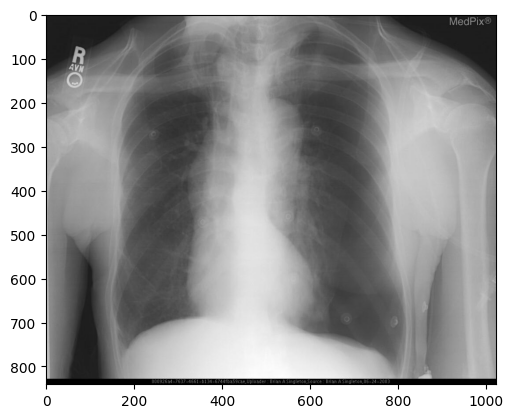

In [21]:
import random 
r = random.randint(0, len(incorrect_df)) 
show_example_pred(incorrect_df.iloc[r].to_dict())


qid: 571
Question: How many instances of intussusception are in the image?
Answer: One
Question type: COUNT
Answer type: OPEN
Predicted Answer: liver
Predicted Answer Type: OPEN


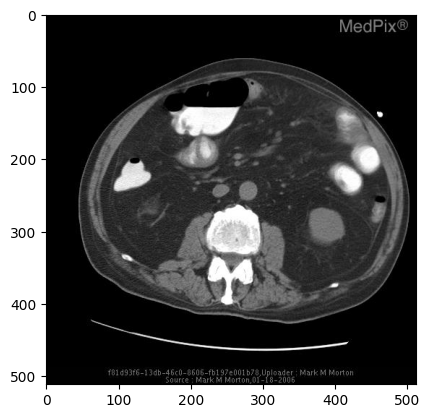

In [22]:
r = random.randint(0, len(incorrect_df)) 
show_example_pred(incorrect_df.iloc[r].to_dict())

### Check question type classification results 

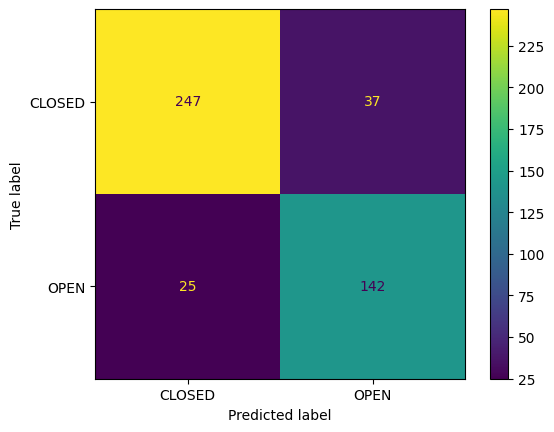

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# merge correct and incorrect 
labels = ['CLOSED', 'OPEN']
df =correct_df.append(incorrect_df, ignore_index=True)
q_true = df['answer_type']
q_pred = df['predicted_answer_type']
cm = confusion_matrix(q_true, q_pred, labels = labels)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [24]:

wrong_type_df = incorrect_df.loc[~(incorrect_df['answer_type'] == incorrect_df['predicted_answer_type'])]

In [25]:
wrong_type_df.head()

,image_name,question,answer,predicted_answer,answer_type,predicted_answer_type,qid,question_type
2,synpic13385.jpg,What is in the left apex?,A bullous lesion,yes,OPEN,CLOSED,718,PRES
3,synpic26764.jpg,Is there hypoinflation or hyperinflation of th...,Hyperinflation,cerebellum,CLOSED,OPEN,2951,SIZE
5,synpic55464.jpg,What plane is this film,coronal,base,OPEN,CLOSED,1132,PLANE
6,synpic38531.jpg,"Are pleural opacities located on the left, rig...",Both,cartilage is not well viewed by xrays,CLOSED,OPEN,2770,POS
8,synpic55583.jpg,Is there any abnormality in this image?,Yes,bullous lesion,CLOSED,OPEN,1943,ABN


In [26]:
right_type_wa = incorrect_df.loc[(incorrect_df['answer_type'] == incorrect_df['predicted_answer_type'])]

## Check which question_types are wrongly predicted the most 
1. use incorrect_df
2. use right_type_wa 


In [27]:
wa_q = incorrect_df['question_type'].value_counts() # ratio 
wa_q

PRES            45
POS             20
ABN             16
SIZE            13
MODALITY         9
PLANE            8
OTHER            6
COUNT            5
ATTRIB           4
ORGAN            3
PRES, ATTRIB     1
Name: question_type, dtype: int64

In [28]:
rtwa_q = right_type_wa['question_type'].value_counts()
rtwa_q 

PRES            21
POS             12
ABN              8
MODALITY         6
SIZE             5
OTHER            5
PLANE            4
ORGAN            3
COUNT            2
PRES, ATTRIB     1
ATTRIB           1
Name: question_type, dtype: int64

In [29]:
import pandas as pd
import numpy as np

base = testset['question_type'].value_counts()
base.name = 'base'
wa_q.name = 'wrong_answer'
rtwa_q.name = 'right_type_wrong_answer'
merged = pd.concat([base, wa_q, rtwa_q],axis=1)
merged

,base,wrong_answer,right_type_wrong_answer
PRES,163,45.0,21.0
POS,58,20.0,12.0
ABN,56,16.0,8.0
SIZE,45,13.0,5.0
MODALITY,33,9.0,6.0
OTHER,26,6.0,5.0
PLANE,26,8.0,4.0
ATTRIB,17,4.0,1.0
ORGAN,10,3.0,3.0
COUNT,6,5.0,2.0


In [30]:
# the ratio of qtype being wrongly predicted 
# count 和 Pres, Attrib 都很少，比例看起來高但例子不多，1 - 5 個
# POS 是 12/58 = 0.344828 ，比較值得研究
# size 是 5/45 
 
wa_q.divide(base).replace(np.nan, 0).sort_values(ascending  = False)

COUNT           0.833333
PRES, ATTRIB    0.500000
POS             0.344828
PLANE           0.307692
ORGAN           0.300000
SIZE            0.288889
ABN             0.285714
PRES            0.276074
MODALITY        0.272727
ATTRIB          0.235294
OTHER           0.230769
POS, PRES       0.000000
COLOR           0.000000
PRES, COLOR     0.000000
PRES, POS       0.000000
ATTRIB, PRES    0.000000
SIZE, PRES      0.000000
dtype: float64

In [31]:
# the ratio of qtype being wrongly predicted, considering only those correctly predicted CLOSED/OPEN ones 
rtwa_q.divide(base).replace(np.nan, 0).sort_values(ascending  = False)

PRES, ATTRIB    0.500000
COUNT           0.333333
ORGAN           0.300000
POS             0.206897
OTHER           0.192308
MODALITY        0.181818
PLANE           0.153846
ABN             0.142857
PRES            0.128834
SIZE            0.111111
ATTRIB          0.058824
COLOR           0.000000
POS, PRES       0.000000
ATTRIB, PRES    0.000000
PRES, COLOR     0.000000
PRES, POS       0.000000
SIZE, PRES      0.000000
dtype: float64

In [32]:
wrong_ = incorrect_df[incorrect_df.question_type =='PRES']
wrong_.shape

qid: 821
Question: Is there herniation?
Answer: No
Question type: PRES
Answer type: CLOSED
Predicted Answer: enlarged
Predicted Answer Type: CLOSED


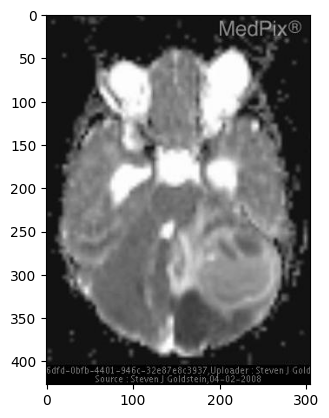

In [36]:
# sample a wrong `q_type` example 
r = random.randint(0, len(wrong_))
row = wrong_.iloc[r]
show_example_pred(row) # herniation 椎間盤突出症

qid: 3027
Question: Was a CT or MRI used to take the above image?
Answer: MRI
Question type: MODALITY
Answer type: CLOSED
Predicted Answer: ct
Predicted Answer Type: CLOSED


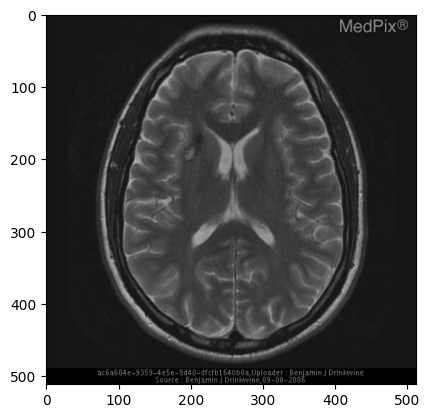

In [45]:
wrong_ = incorrect_df[incorrect_df.question_type =='MODALITY']
wrong_.shape
# sample a wrong `q_type` example 
r = random.randint(0, len(wrong_))
row = wrong_.iloc[r]
show_example_pred(row) # herniation 椎間盤突出症

## Check what those 56 closed answers are 

In [58]:
# check testset closed answer 
closed = testset.loc[(testset.answer_type == 'CLOSED')]


In [59]:
# normalize to all lowercase 
closed = closed.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
closed.nunique()
# list all closed ans 

qid              272
image_name       146
image_organ        3
answer            17
answer_type        1
question_type     15
question         256
phrase_type        2
dtype: int64

In [66]:
closed

,qid,image_name,image_organ,answer,answer_type,question_type,question,phrase_type
0,11,synpic42202.jpg,chest,yes,closed,pres,is there evidence of an aortic aneurysm?,freeform
1,13,synpic29265.jpg,chest,yes,closed,pres,is there airspace consolidation on the left side?,freeform
2,14,synpic54610.jpg,head,yes,closed,plane,is this an axial plane?,freeform
4,22,synpic54610.jpg,head,yes,closed,abn,is there vascular pathology in this image?,freeform
5,24,synpic42202.jpg,chest,yes,closed,size,is there cardiomyopathy?,freeform
...,...,...,...,...,...,...,...,...
442,3059,synpic25587.jpg,chest,no,closed,pres,is there any tracheal deviation present?,freeform
443,3061,synpic25587.jpg,chest,no,closed,pres,is the trachea deviated in this image?,para
448,3132,synpic47191.jpg,abd,yes,closed,"pres, color",is the gi tract is highlighted by contrast?,freeform
449,3136,synpic676.jpg,chest,no,closed,size,do you see cardiomegaly?,para


In [61]:
closed_ans = closed['answer'].unique()

In [62]:
closed_ans

array(['yes', 'no', 'one', 'left', 'smaller', 'supratentorial', 'mri',
       'female', 'right', 'cystic', 'abnormal', 'right side', 'both',
       'bilateral', 'axial', 'flair', 'hyperinflation'], dtype=object)